# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Feature selection](#fourth-bullet)
5. [Missing Values, Split and Scale](#fifth-bullet)
   * Scale-Normaliza values
   * Split the data in train and test set
   
6. [Model regressor](#sixth-bullet)
    * Cross-validation

## Import modules and data <a class="anchor" id="first-bullet"></a>

In [13]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import plot_importance

# sklear stuff
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as ecm


import warnings
warnings.filterwarnings('ignore')

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
%aimport visualization.visualize
import data.make_dataset as md
import features.build_features as bf
import visualization.visualize as vs

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# Keep Riesgo for future evaluation
RIESGO = df_raw['RIESGO']

# Drop Grisen and RIESGO base on previous data exploration
df_raw = df_raw.drop(['GRISEN_NR'], axis=1)
df_raw = df_raw.drop(['RIESGO'], axis=1)

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index
print('Shape:', df_raw.shape)
display(df_raw.head())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 8)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,pred_24h,pred_48h,pred_72h
time,,,,,,,,
2008-01-01 00:00:00,0.8100,1.6000,0.2675,0.7875,0.74,0.750,0.7400,0.76
2008-01-01 01:00:00,0.8100,1.6075,0.2650,0.7900,0.74,0.745,0.7325,0.76
2008-01-01 02:00:00,0.8100,1.6100,0.2675,0.7900,0.74,0.740,0.7300,0.76
2008-01-01 03:00:00,0.8075,1.6100,0.2600,0.7900,0.74,0.740,0.7200,0.76
2008-01-01 04:00:00,0.8000,1.6025,0.2650,0.7900,0.74,0.740,0.7200,0.76


In [14]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'}

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/AEMET/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [15]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo], axis=1)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 16)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,pred_24h,pred_48h,pred_72h,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
2018-12-07 19:00:00,0.9850,1.7300,0.52,0.8450,1.05,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,0.9800,1.7475,0.52,0.8450,1.05,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,0.9675,1.7500,0.52,0.8375,1.05,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,0.9550,1.7400,0.52,0.8300,1.05,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,0.9450,1.7375,0.52,0.8300,1.05,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


## Data exploration <a class="anchor" id="second-bullet"></a>

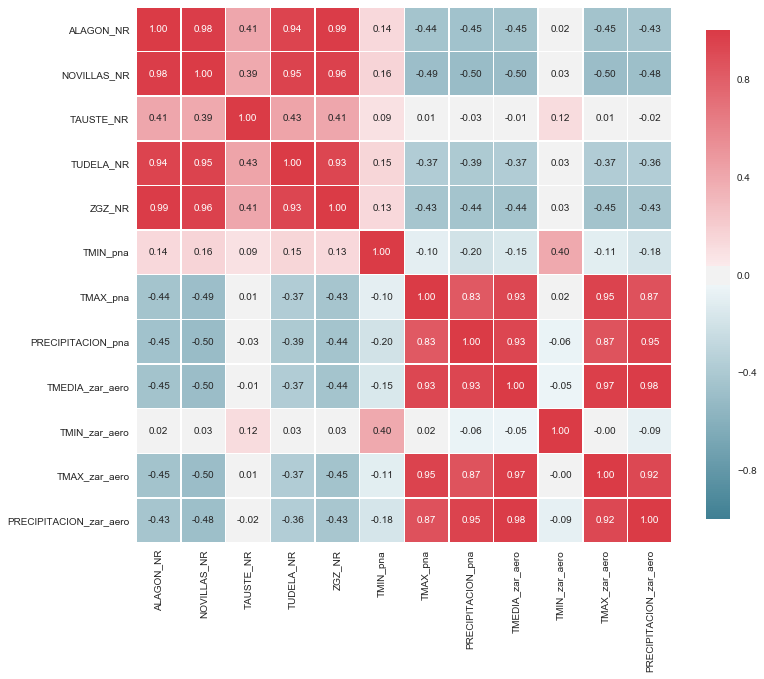

In [16]:
vs.corr_heatmap(pd.concat([df.iloc[:,:5], df.iloc[:,9:]], axis=1))

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [27]:
data = X.copy(deep=True)
cols = cols_delt
hrs = 5

columns_x[:5]

['ALAGON_NR', 'NOVILLAS_NR', 'TAUSTE_NR', 'TUDELA_NR', 'ZGZ_NR']

In [17]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
X = bf.delta_height(X, cols_delt, 1, True)
X = bf.delta_height(X, cols_delt, 5, True)

# number of derived columns per feature
N = 1  

# time delta in hr
delta = [8, 145]

# Create new shifted features
dup_cols = ['TUDELA_NR', 'NOVILLAS_NR']
X = bf.column_shift(X, dup_cols, N, delta[0])

dup_cols = ['ALAGON_NR', 'ZGZ_NR']
X = bf.column_shift(X, dup_cols, N, delta[1]) 

print('Shape:', X.shape)
display(X.head())

Shape: (95850, 27)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145
2008-01-01 06:00:00,0.800,1.590,0.2600,0.7825,0.7425,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0025,0.0020,0.0035,0.0010,0.0015,-0.0005,NaN,NaN,NaN,NaN
2008-01-01 07:00:00,0.795,1.590,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0075,0.0030,0.0040,0.0030,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 08:00:00,0.790,1.595,0.2550,0.7750,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0035,0.0030,0.0010,0.0030,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 09:00:00,0.790,1.600,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,0.0005,0.0025,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 10:00:00,0.790,1.610,0.2550,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,-0.0030,0.0005,0.0020,-0.0020,NaN,NaN,NaN,NaN


## Missing Values, Split and Scale <a class="anchor" id="fifth-bullet"></a>

In [6]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                 0
NOVILLAS_NR               0
TAUSTE_NR                 0
TUDELA_NR                 0
ZGZ_NR                    0
TMEDIA_pna                0
TMIN_pna                  0
TMAX_pna                  0
PRECIPITACION_pna         0
TMEDIA_zar_aero           0
TMIN_zar_aero             0
TMAX_zar_aero             0
PRECIPITACION_zar_aero    0
delta_1_ALAGON_NR         0
delta_1_NOVILLAS_NR       0
delta_1_TAUSTE_NR         0
delta_1_TUDELA_NR         0
delta_1_ZGZ_NR            0
delta_5_ALAGON_NR         0
delta_5_NOVILLAS_NR       0
delta_5_TAUSTE_NR         0
delta_5_TUDELA_NR         0
delta_5_ZGZ_NR            0
TUDELA_NR_8               0
NOVILLAS_NR_8             0
ALAGON_NR_145             0
ZGZ_NR_145                0
TAUSTE_NR_145             0
dtype: int64

### Scale-Normaliza values

In [7]:
# MinMax scale
scaler = MinMaxScaler()
columnas = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columnas)

### Split the data in train and test set

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
display(x_train.head())

(53254, 28)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145,TAUSTE_NR_145
823,0.148936,0.216252,0.024752,0.065456,0.099467,0.266667,0.093949,0.262500,0.252927,0.287791,...,0.662147,0.748025,0.656595,0.534722,0.667401,0.063545,0.224544,0.054010,0.030639,0.023338
3218,0.319476,0.336982,0.062235,0.155757,0.233570,0.602778,0.000000,0.453125,0.679157,0.636628,...,0.697175,0.751536,0.663965,0.539352,0.731278,0.155757,0.346269,0.455646,0.307726,0.079915
14353,0.070049,0.070978,0.028996,0.048256,0.058615,0.550000,0.050955,0.637500,0.449649,0.674419,...,0.637288,0.823529,0.656595,0.541667,0.685022,0.042523,0.114760,0.074304,0.063943,0.030410
1822,0.423241,0.443118,0.070014,0.195413,0.289520,0.388889,0.076433,0.456250,0.313817,0.447674,...,0.636158,0.744513,0.656595,0.601852,0.709251,0.211180,0.436153,0.302782,0.207815,0.036068
22071,0.067758,0.086235,0.056577,0.045867,0.058615,0.766667,0.000000,0.609375,0.840749,0.779070,...,0.628249,0.746269,0.657332,0.550926,0.685022,0.043000,0.088889,0.048118,0.041297,0.060113


## Model regressor <a class="anchor" id="sixth-bullet"></a>

In [9]:
# XGBoost regresor
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

kfold = KFold(n_splits=10, random_state=7)
scoring = 'r2'

scores = cross_val_score(xgb, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0))
print('Confidence interval 66%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2))
print('Confidence interval 95%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2.6))
print('Confidence interval 99%')

Accuracy: 85.41 (+/- 5.26)
Confidence interval 66%
Accuracy: 85.41 (+/- 10.52)
Confidence interval 95%
Accuracy: 85.41 (+/- 13.67)
Confidence interval 99%
